In [2]:
import pandas as pd
import numpy as np
from surprise import Dataset
from surprise import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD
from surprise.model_selection import cross_validate
import difflib
import random
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
from surprise import accuracy
from surprise.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)

# Collaborative Filtering Recommender System
Collaborative filtering system uses similarities between users and items to provide recommendations. As such, this recommendation system requires user's historical choices and their ratings on those choices, but does not require much of the product features. The process of the recommender system is to make a guess on what the user will rate items that they have not tried before and recommend items with a high predicted rating. 

In [3]:
#Import recipes data
df = pd.read_csv('Cleaned_recipes.csv')

In [4]:
#Import review data
df_review = pd.read_csv('Cleaned_reviews.csv')

In [5]:
df.head(5)

,Unnamed: 0,RecipeId,RecipeName,RecipeCategory,Keywords,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeInstructions,serving_size,servings,ingredients,ingredients_raw_str,minutes,n_steps,n_ingredients,AggregatedRating,ReviewCount,year,month,day_of_week
0,0,120,Carrot Cake II,Dessert,['Vegetable' 'Weeknight' 'Oven' '< 4 Hours'],1173.5,69.8,19.4,154.7,720.2,129.9,3.7,89.4,11.5,['Preheat oven to 325°.'\n 'Add 1 egg at a tim...,309,8,"['carrot', 'egg', 'sugar', 'all purpose flour'...","[""1 lb carrot, freshly grated "",""4 larg...",75,11,13,4.25,4.0,1999,9,6
1,1,122,Commissary Carrot Cake,Dessert,['Vegetable' 'Low Protein' 'Weeknight' 'For La...,1011.8,67.4,28.3,146.0,401.4,101.3,4.5,80.1,7.4,"['In a heavy saucepan,blend well the flour,sug...",246,16,"['sugar', 'flour', 'salt', 'heavy cream', 'uns...","[""1 1/2 cups sugar"",""1/4 cup flour"",""3...",240,34,18,3.00,1.0,1999,9,3
2,2,123,Carrot Maple Cheesecake,Cheesecake,['Dessert' 'Weeknight' 'Oven' '< 4 Hours'],302.5,20.3,11.0,103.0,320.9,22.9,0.9,16.8,8.2,['CRUST: Combine ingredients; mix well.'\n 'P...,139,12,"['graham crackers', 'butter', 'carrot', 'light...","["""",""1 1/3 cups graham crackers (12 cookie...",110,13,9,4.33,9.0,1999,9,0
3,3,124,Catherine's Excellent Yorkshire Pudding,Dessert,['Healthy' '< 60 Mins' 'Oven'],141.6,2.6,1.1,50.8,73.1,23.4,0.8,0.1,5.5,['Sieve the flour into mixing bowl.' 'Add the ...,67,4,"['plain flour', 'salt', 'garlic salt', 'black ...","[""4 ounces plain flour"",""1 pinch sal...",35,6,7,4.50,2.0,1999,9,0
4,4,126,Carnation Lean Fettuccine Alfredo,Vegetable,['Healthy' '< 60 Mins'],535.7,15.9,7.4,110.6,588.1,69.7,3.7,2.5,28.6,"['In a large pot of boiling water, cook the fe...",298,4,"['fettuccine', 'olive oil', 'garlic', 'milk', ...","[""12 ounces fettuccine"",""1 teaspoon ...",40,9,13,2.67,9.0,1999,8,5


In [6]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [7]:
df_review.head()

,Unnamed: 0,User,RecipeId,Rating
0,0,2008,992,5
1,7,2156,148,0
2,8,2046,517,5
3,19,2625,471,3
4,21,2312,780,5


In [8]:
df_review.drop(columns = 'Unnamed: 0', inplace = True)

In [9]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765139 entries, 0 to 765138
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   User      765139 non-null  int64
 1   RecipeId  765139 non-null  int64
 2   Rating    765139 non-null  int64
dtypes: int64(3)
memory usage: 17.5 MB


# Sample User input

In [10]:
df_input = df_review[df_review['User'] == 2312]

In [11]:
df_input = df_input.sort_values(by='Rating', ascending=False).head(10)

In [12]:
df_input

,User,RecipeId,Rating
4,2312,780,5
123918,2312,148066,5
52981,2312,37634,5
6,2312,51964,5
47564,2312,48537,5
113793,2312,107090,5
113794,2312,108281,5
44507,2312,8679,5
38298,2312,26205,5
123917,2312,72072,5


In [13]:
top_recipes = df_input['RecipeId']

In [14]:
df_recipes = df[df['RecipeId'].isin(top_recipes)]

In [15]:
df_recipes.loc[:,['RecipeName','AggregatedRating']].sort_values(by='AggregatedRating', ascending=False)

,RecipeName,AggregatedRating
247,Indian Spiced Chicken,5.00
13006,Szechuan Pepper-Salt Prawns,5.00
43383,"Bread Stuffing W/ Pears, Bacon, Pecans & Caram...",5.00
17792,Chiffonade of Brussels Sprouts with Bacon &amp...,4.78
1170,Lamb Leg Steak With Maple Chevre Shiitake Sauce,4.00
7560,"Classic Pie Crust, Idiot Proof Step-By-Step Ph...",4.00
59493,Martha Stewart's Eggnog,4.00
19300,Roasted Potatoes With Tomatoes &amp; Rosemary,3.67
43891,Best Ever Pie Crust!,3.33
28207,Roast Prime Rib of Beef With Pink and Green Pe...,0.00


# Matrix Factorization - Funk SVD
Matrix Factorization is a crucial step in the collaborative filtering system. The objective of the matrix is to factorize a user-item matrix into two low-ranked matrices, (1) user-factor matrix and (2) item-factor matrix. The decomposition into two matrices will help generate latent or hidden factors of the characteristics of the item and prefrences of the users, which will help predict user ratings on new unseen recipes.<br>

The downfall to Singular Value Decomposition is that it doesn't work well with a spare-martrix (lot of NaN values, which means that the user has never tried the recipe). In order to compensate for this, we use Funk SVD. Funk SVD will ignore the missing values and compute the latent factors (hidden factors) on only the values that we know.

### More about latent features
Latent features cannot be observed in our data, instead it is infered based on the ratings given by the user of the recipe. These features represent characteristics of the recipes and preferences of the user. 

In [16]:
#Initializing FunkSVD algorithm
my_reader = Reader(rating_scale = (1,5))

df_review_data = Dataset.load_from_df(df_review, my_reader)

## Funk SVD Parameters & Evaluation Metrics
There are various parameters that will need to be fine tuned to attain the best evaluation metrics for our model. Before we start with out parameters, we can start with the evaluation metrics for the Funk SVD model. <br>

### Evaluation Metrics
**Root Mean Square Error (RMSE)** <br>
RMSE measures the average squared difference between the predicted ratings and actual ratings. A lower RMSE score indicates a better model performance. 

**Mean Absolute Error** <br>
MAE measures the absolute difference between predicted and actual ratings. A lower MAE socre indicates a better model performance. 

With the two evaluation metrics mentioned above, there are a couple of flaws. <br>
1. Score can only be computed if a recipe has been rated. This means unseen recipes will not be rated. As such, this defeats a part of the goal of a recommender system as it will cannot recommend a unseen recipes. 
2. Better score prediction does not lead to better recommendations. Although a recipe may have a high accuracy predicting the rating of th recipe, it may not be a relevant recipe to the user. This defeats the purpose a recommender system.

To combat this issue, we need to use "Ranking Based Methods" to help measure the quality of the items ranking.

**Fraction of Concordant Pairs (FCP)** <br>
FCP quanitfies the extent of which the recommendation system correctly ranks the items in comparison to the user's preferecnes. It is a measure of the pairwise ordering of items. <br>

**How FCP works?** <br>
For each user, all possible pairs of items for that user is compared to each other to determine which ranks higher. If a pair of items' predicted ranking is the same as the actual ranking, the pair is considered a concordant pair. If it is not, it is considered a disconcordant pair. To calculate the FCP score, we take the number of concordant pairs and divided it by the total number of pairs. A higher FCP score indicates a better ranking system score.


In [17]:
#Setting up Parameter grid
param_grid = {
    'n_factors': [100],
    'n_epochs': [10],
    'lr_all': [0.005],
    'biased': [False]}

#Set GridSearchCV with 3 cross validation
GS = GridSearchCV(FunkSVD, param_grid, measures = ['fcp', 'rmse', 'mae'])

#Fit Model
GS.fit(df_review_data)

In [18]:
#Setting up Parameter grid
param_grid = {
    'n_factors': [100, 150, 200],
    'n_epochs': [10, 20 , 30],
    'lr_all': [0.005, 0.01, 0.1],
    'biased': [False]}

#Set GridSearchCV with 3 cross validation
GS = GridSearchCV(FunkSVD, param_grid, measures = ['fcp', 'rmse', 'mae'], cv = 3)

#Fit Model
GS.fit(df_review_data)

In [19]:
#Check FCP accuracy score
best_fcp = GS.best_score['fcp']
best_rmse = GS.best_score['rmse']
best_mae = GS.best_score['mae']

print("Best FCP Score", best_fcp)
print("Best RMSE Score", best_rmse)
print("Best MAE Score", best_mae)

Best FCP Score 0.5905422988979043
Best RMSE Score 1.3142017158509118
Best MAE Score 0.6372641109712557


In [20]:
#Check best param
fcp_param = GS.best_params['fcp']
rmse_param = GS.best_params['rmse']
mae_param = GS.best_params['mae']

print("Best FCP param", fcp_param)
print("Best RMSE param", rmse_param)
print("Best MAE param", mae_param)

Best FCP param {'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.005, 'biased': False}
Best RMSE param {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.1, 'biased': False}
Best MAE param {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.1, 'biased': False}


Best param that nets best result for the FCP score is: {'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.005, 'biased': False}. These parameters netted a 58.6% FCP score meaning that 58.6% of the time the recommendation system ranked one item higher than another in accordance with the user's actual preferences. 

Build algorithm on train test set to check accuracy

In [21]:
#Train test split
trainset, testset = train_test_split(df_review_data, test_size = 0.2)

#Set algorithm
review_algo = FunkSVD(n_factors = 100,
                     n_epochs = 10,
                     lr_all = 0.005,
                     biased = False,
                     verbose = 0)

#Fit train set
review_algo.fit(trainset)

#Test algo using test set
prediction = review_algo.test(testset)

In [22]:
# Put my_pred result in a dataframe
df_prediction = pd.DataFrame(prediction, columns=['user_id',
                                                     'recipe_id',
                                                     'actual',
                                                     'prediction',
                                                     'details'])

# Calculate the difference of actual and prediction into diff column
df_prediction['diff'] = abs(df_prediction['prediction'] - 
                            df_prediction['actual'])

In [23]:
# Check the df_prediction
df_prediction.head()

,user_id,recipe_id,actual,prediction,details,diff
0,757556,48878,5.0,2.033947,{'was_impossible': False},2.966053
1,17206,61799,5.0,1.000000,{'was_impossible': False},4.000000
2,37305,107343,3.0,1.500818,{'was_impossible': False},1.499182
3,364685,204926,4.0,2.920974,{'was_impossible': False},1.079026
4,228172,35525,5.0,2.197103,{'was_impossible': False},2.802897


In [24]:
# See the best 10 predictions
df_prediction.sort_values(by='diff')[:10]

,user_id,recipe_id,actual,prediction,details,diff
76513,216165,121897,5.0,5.0,{'was_impossible': False},0.0
22506,13063,31128,5.0,5.0,{'was_impossible': False},0.0
110033,584814,166030,5.0,5.0,{'was_impossible': False},0.0
110029,47723,119158,5.0,5.0,{'was_impossible': False},0.0
110014,147027,34881,5.0,5.0,{'was_impossible': False},0.0
110003,150281,23495,5.0,5.0,{'was_impossible': False},0.0
109994,38182,52556,5.0,5.0,{'was_impossible': False},0.0
109982,1206650,222188,5.0,5.0,{'was_impossible': False},0.0
22547,314579,16399,5.0,5.0,{'was_impossible': False},0.0
109970,482376,210258,5.0,5.0,{'was_impossible': False},0.0


In [25]:
#Check rows where predicted rating equals actual rating
(df_prediction['diff'] == 0).mean()

0.05693729252163003

About 6.2% of data have same prediction rating with actual rating. 

In [26]:
#Check rows where predicted rating is almost equal to actual rating
(df_prediction["diff"] <= 1).mean()

0.41050003920851086

About 42.8% of predictions are almost accurate

Now we are going to apply the model onto the full trainset

In [27]:
#Initializing FunkSVD algorithm
my_reader = Reader(rating_scale = (1,5))

df_review_data = Dataset.load_from_df(df_review, my_reader)

#Build full trainset
full_trainset = df_review_data.build_full_trainset()

#Build Funk SVD algorithm with optimized parameters
review_algo = FunkSVD(n_factors = 10,
                     n_epochs = 100,
                     lr_all = 0.005,
                     biased = False,
                     verbose = 0)

#Fit with full trainset
review_algo.fit(full_trainset)

We can now utilize build_anti_test to build test set for all users and recipes without any ratings. This will allow us to have estimated ratings for all user-recipe rating pairs that are missing from our data.

In [28]:
#Define full test set
# full_testset = full_trainset.build_anti_testset(fill=-1)

Dataset is too big to run build_anti_test. This step will need to be implemented in future state using cloud services

In [29]:
#Getting Latent Variables
User = review_algo.pu
Item = review_algo.qi.T

In [30]:
#Converting User and Item array to DataFrame
User_df = pd.DataFrame(User)
Item_df = pd.DataFrame(Item)

In [31]:
#First recipe
first_recipe = Item[:,0]

**Building Sample User Profile**

In [32]:
#Get first user's profile
user_1 = df_review.loc[1,'User']

inner_user_id = full_trainset.to_inner_uid(user_1)
user_profile = User[inner_user_id]
user_profile

array([ 0.12196009, -0.00929802,  0.04798844,  0.10884224,  0.00625777,
        0.05397132,  0.20094163, -0.05824586,  0.04355289,  0.09538173])

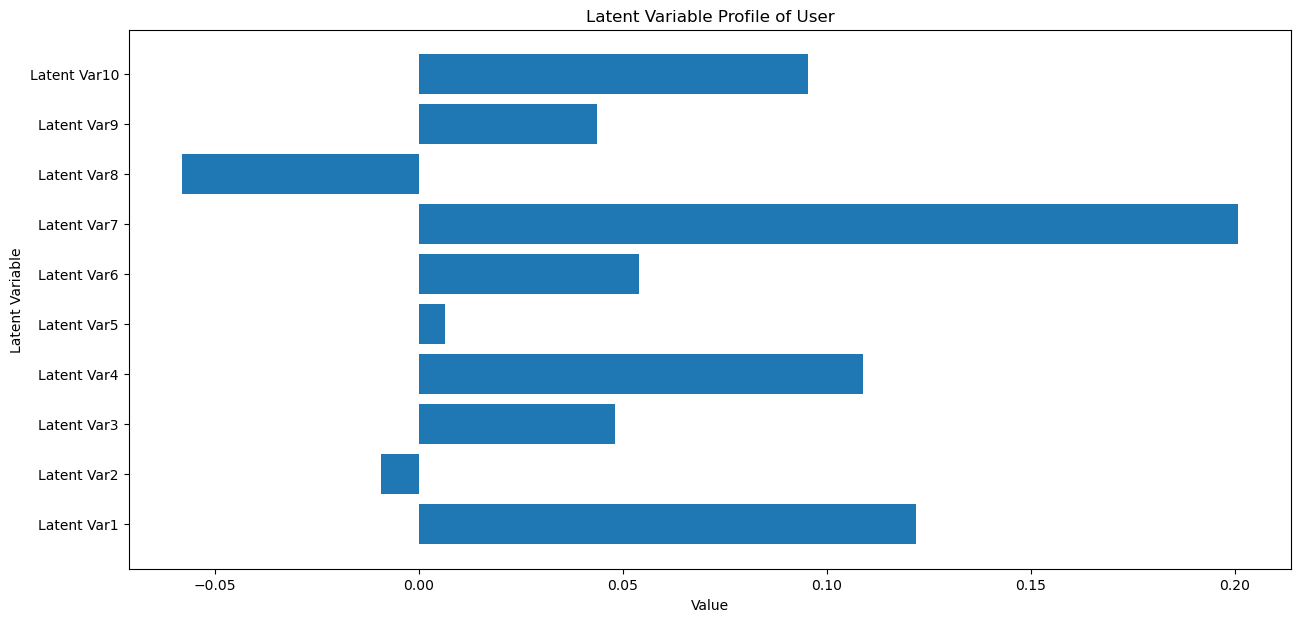

In [33]:
#Plotting Latent Features for user
plt.figure(figsize=(15, 7))
plt.barh([f'Latent Var{i}' for i in range(1,len(first_recipe)+1)], user_profile)
plt.title("Latent Variable Profile of User")
plt.ylabel("Latent Variable")
plt.xlabel("Value")
plt.show()

**Building Sample Recipe Profile**

In [34]:
#Getting recipe profile 
recipe_1 = df.loc[1,'RecipeId']

inner_recipe_id = full_trainset.to_inner_iid(recipe_1)
recipe_profile = Item[:, inner_recipe_id]
recipe_profile

array([-0.24205351, -0.43845139,  0.47817875, -1.2711595 , -0.64394989,
        0.65370099, -0.90780034,  0.66271328,  0.86201881,  0.69949364])

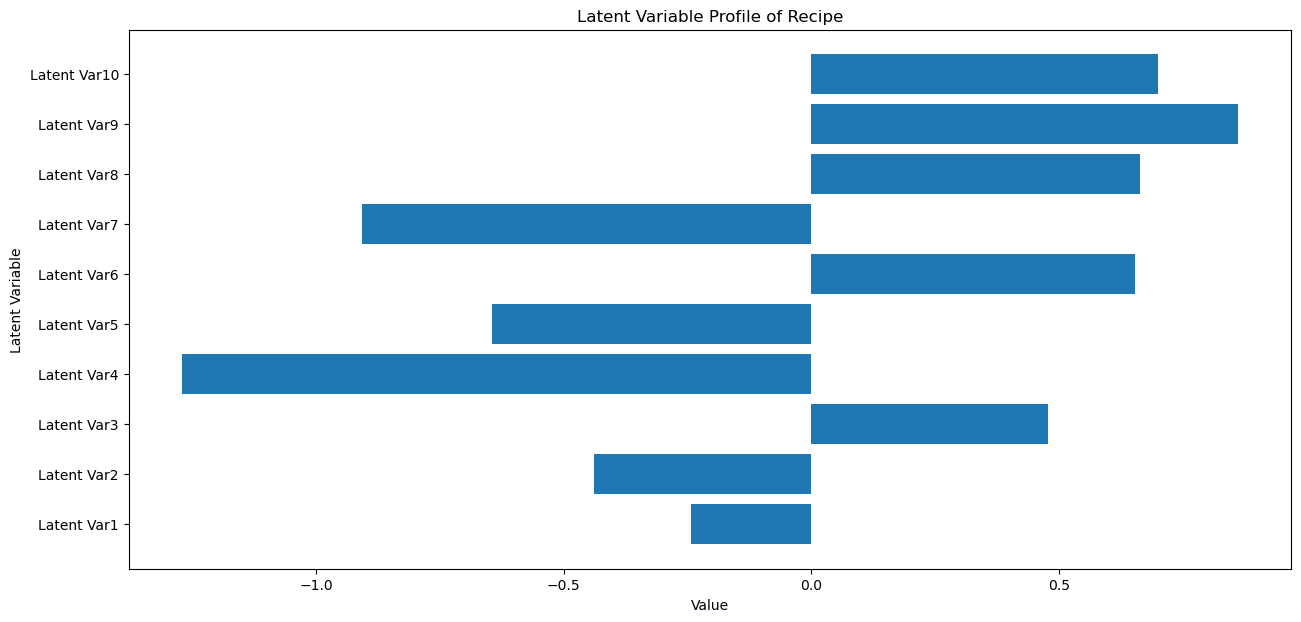

In [35]:
plt.figure(figsize=(15, 7))
plt.barh([f'Latent Var{i}' for i in range(1,len(first_recipe)+1)], recipe_profile)
plt.title("Latent Variable Profile of Recipe")
plt.ylabel("Latent Variable")
plt.xlabel("Value")
plt.show()

### Observations from User and Recipe profiles
The higher the latent variable values and the greater number of positive latent variables indicates that the user has a greater affinity or recipe towards the recipe.

Once we have both the user and recipe profile, we can determine the expected rating by doing a dot product of both profiles.

## Funk SVD & Top N items Function
We are now going to create a top N recommendation system that we can use to recommend recipes to users.

In [36]:
#Example Used id: 1773
df_review[df_review['User'] == 1773]

,User,RecipeId,Rating
66,1773,190,3


In [37]:
df_review.loc[1,'User']

2156

In [38]:
#Get user's profile
input_user = 1773

inner_user_id = full_trainset.to_inner_uid(input_user)
user_profile = User[inner_user_id]

In [39]:
#Getting recipe profile 
recipe_1 = 390157

inner_recipe_id = full_trainset.to_inner_iid(recipe_1)
recipe_profile = Item[:, inner_recipe_id]

In [40]:
#Calculating the expected rating through dot product of the user and recipe profile
expected_rating = np.dot(user_profile, recipe_profile)
expected_rating

1.5573642716441294

Our next step is to rate all unrated recipes from user and rank them top N.

In [41]:
#FunkSVD recommendation
def get_recommendations(input_user, N):
    """
    Function will provide top N recipes based on ratings for the input_user.
    
    input_user: User id
    N: parameters for top number of recipes to return
    
    Output: Dataframe with top N recipes sort by ratings
    
    """
    inner_user_id = full_trainset.to_inner_uid(input_user)
    user_profile = User[inner_user_id]

    rated_recipes = df_review[df_review['User'] == input_user]['RecipeId']

    unrated_recipes = df_review[~df_review['RecipeId'].isin(rated_recipes)]['RecipeId'].unique()

    rating_list = []
    for val in unrated_recipes:
        input_recipe = val

        inner_recipe_id = full_trainset.to_inner_iid(input_recipe)
        recipe_profile = Item[:, inner_recipe_id]

        rating = np.dot(user_profile, recipe_profile)
        rating_list.append(rating)

    min_rating = np.min(rating_list)
    max_rating = np.max(rating_list)

    mapped_rating_list = []
    for rating in rating_list:
        # Map the rating to a 1-5 scale
        mapped_rating = 1 + (rating - min_rating) / (max_rating - min_rating) * 4
        mapped_rating_list.append(mapped_rating)

    top_indices = np.argsort(mapped_rating_list)[::-1][:N]
    top_recipes = [unrated_recipes[i] for i in top_indices]
    top_ratings = [mapped_rating_list[i] for i in top_indices]
    top_recipes_names = [df.loc[df['RecipeId'] == i, 'RecipeName'].iloc[0] for i in top_recipes]
    
    recommendations_df = pd.DataFrame({'RecipeName': top_recipes_names, 'Rating': top_ratings})
    return recommendations_df

In [42]:
get_recommendations(2312,10)

,RecipeName,Rating
0,The Real New York Bagel Recipe,5.000000
1,Bahama Mama Banana Rum Cake,4.691409
2,Gluten Free Waffles,4.690982
3,Betty Crocker Fudge Brownies Homemade,4.643886
4,The Best Puerto Rican Pernil (Pork Shoulder),4.592381
5,Vegetable Lasagna With White Sauce,4.566935
6,Best Ever Banana Cake With Cream Cheese Frosting,4.557698
7,Homemade Blackberry Jam,4.538023
8,Starbucks Mocha Frappuccino,4.522249
9,The Best Ever Waffles,4.512317


# Observation
We aren't able to fully use collaborative filtering with our business use case building out a constructed grocery list based on user's input of ingredients, but we may be able to use a hybrid recommender system to utilizes the Funk SVD algorithm and the content based recommender. Further actions on this will be discussed when constructing the hybrid model.

Based on the Fraction of Concordant Pairs metric score, we only attained a score of 58% with the most optimized hyperparameters. This score is very medicore and we will need to run other collaborative recommender systems to determine if we can get a better model for prediction.. Although this is the case, the model is performing better than random chance of 50/50.



# Stochastic Gradient Descent

In [43]:
# Step 2: Define hyperparameters
num_users, num_items = R.shape
K = 2  # Number of latent factors
learning_rate = 0.01  # Learning rate
reg_lambda = 0.1  # Regularization parameter
num_iterations = 1000  # Number of iterations

NameError: name 'R' is not defined

In [ ]:
df_review.head(5)

In [ ]:
df_review['RecipeId'].isnull().values.any()

In [ ]:
df_review_2 = df_review.drop_duplicates()

In [ ]:
# Step 1: Create a User-Item Interaction Matrix
user_item_matrix = df_review_2.pivot(index='User', columns='RecipeId', values='Rating')



In [ ]:
df_review.iloc[129132711,:]

In [ ]:
print(df_review['User'].unique())